In [ ]:
# default_exp dualrnn
# default_cls_lvl 3

In [ ]:
#hide
# %load_ext line_profiler

# Dual RNN Models
> Pytorch Models for Sequential Data

In [ ]:
#export
from seqdata.core import *
from seqdata.models.core import *
from seqdata.learner import *
from seqdata.dataloaders import *
from fastai.basics import *
from fastai.callback.progress import *
from fastai.callback.schedule import *

In [ ]:
init_sz = 100
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['current','voltage'],TensorSequencesInput,clm_shift=[0,-1]),
                        SequenceBlock.from_hdf(['voltage'],TensorSequencesOutput,clm_shift=[-1])),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=20000+1,stp_sz=2000,clm='current')]),
                 splitter=ApplyToDict(ParentSplitter()))
dl_kwargs=[{'sub_seq_len':1000}]*2
db = seq.dataloaders(get_hdf_files('test_data/'),bs=32,dl_type=TbpttDl,dl_kwargs=dl_kwargs)

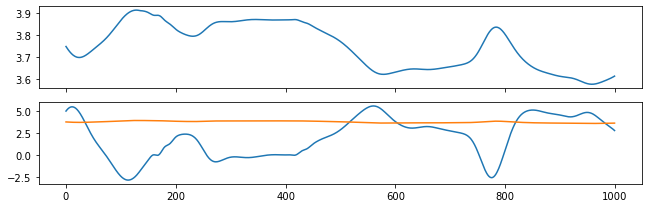

In [ ]:
db.show_batch(max_n=1)

## NarProg

In [ ]:
#export
class Diag_RNN(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,input_size,output_size,output_layer=1,hidden_size=100,
                 rnn_layer=1,linear_layer = 1,stateful=True,**kwargs):
        super().__init__()
        self.output_size = output_size
        
        self.rnn = RNN(input_size,hidden_size,rnn_layer,stateful=stateful,ret_full_hidden=False,**kwargs) 
        self.final = SeqLinear(hidden_size,int(output_size*output_layer),hidden_layer=linear_layer-1)

    def forward(self, x,init_state = None):
        out,hidden = self.rnn(x,init_state)
        out = self.final(out)
        out = torch.stack(torch.split(out, split_size_or_sections = self.output_size,dim = -1),0)
        return out,hidden
    
    def output_to_hidden(self, out, idx):
        hidden = list(out[:,None,:,idx])
#         hidden = torch.split(out[:,:,idx],split_size_or_sections=1,dim = 0)
        hidden = [ h.contiguous() for h in hidden]
        return hidden
    
    def _get_hidden(self,bs):
        return self.rnn._get_hidden(bs)

In [ ]:
#export
class Diag_RNN_raw(nn.Module):
    
    def __init__(self,input_size,output_size,output_layer=1,hidden_size=100,
                 rnn_layer=1,linear_layer = 1,stateful=True):
        super().__init__()
        
        self.rnn = RNN(input_size,output_size,output_layer,stateful=stateful,ret_full_hidden=True) 

    def forward(self, x,init_state = None):
        
        return self.rnn(x,init_state)

In [ ]:
#export
class NarProg(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,prog_input_size,diag_input_size,output_size,init_sz=100,hidden_size=100,
                 rnn_layer=1,linear_layer = 1,**kwargs):
        super().__init__()
        store_attr('prog_input_size,diag_input_size,init_sz')
        
        rnn_kwargs = dict(hidden_size=hidden_size,num_layers=rnn_layer,stateful=True,ret_full_hidden=True)
        rnn_kwargs = dict(rnn_kwargs, **kwargs)
        
        self.rnn_diagnosis = Diag_RNN(diag_input_size,output_size=hidden_size,hidden_size=hidden_size,output_layer=rnn_layer,rnn_layer=rnn_layer,**kwargs) 
#         self.rnn_diagnosis = Diag_RNN_raw(diag_input_size,hidden_size,num_layers=rnn_layer,ret_full_hidden=True,stateful=True) 
        self.rnn_prognosis = RNN(prog_input_size,**rnn_kwargs) 

#        self.final = SeqLinear(int(hidden_size*rnn_layer),output_size,hidden_layer=0)
        self.final = SeqLinear(hidden_size,output_size,hidden_layer=0)
        
        self.reset_state()

    def forward(self, x,init_state = None):
        bs = x.shape[0]
        if init_state is None: init_state = self._get_hidden(bs)
        x_diag = x[...,:self.diag_input_size]
        x_prog = x[...,:self.prog_input_size]
        
        if self.training:
            #in training, estimate the full sequence with the diagnosis module
            if init_state is None:
                #execution with no initial state
                out_diag,_ = self.rnn_diagnosis(x_diag)
                h_init = self.rnn_diagnosis.output_to_hidden(out_diag,self.init_sz-1)
                new_hidden = self.rnn_diagnosis.output_to_hidden(out_diag,-1)
                
                out_prog,_ = self.rnn_prognosis(x_prog[:,self.init_sz:],h_init)  
                out_prog=torch.cat([out_diag[:,:,:self.init_sz],out_prog],2) 
            else:
                #import pdb; pdb.set_trace()
                out_prog,_ = self.rnn_prognosis(x_prog,init_state)
                out_diag,_ = self.rnn_diagnosis(x_diag)
                new_hidden = self.rnn_diagnosis.output_to_hidden(out_diag,-1)
        else:
#             import pdb; pdb.set_trace()
            #in inference, use the diagnosis module only for initial state estimation
            if init_state is None:
                out_init,_ = self.rnn_diagnosis(x_diag[:,:self.init_sz])
                h_init = self.rnn_diagnosis.output_to_hidden(out_init,-1)
                out_prog,new_hidden = self.rnn_prognosis(x_prog[:,self.init_sz:],h_init)  
                out_prog=torch.cat([out_init,out_prog],2) 
            else:         
                out_prog,new_hidden = self.rnn_prognosis(x_prog,init_state)

        self.hidden =  to_detach(new_hidden, cpu=False, gather=False)
        #Shared Linear Layer
        result = self.final(out_prog[-1])
        return result

    def _get_hidden(self,bs):
        '''retrieve internal hidden state, check if model device has changed'''
        if self.hidden is None: return None
        if bs!=self.hidden[0].shape[1]: return None
        if self.hidden[0][0].device != one_param(self).device: return None
        return self.hidden
    
    def reset_state(self):
        self.hidden = None

In [ ]:
#export
from fastai.callback.hook import *
class NarProgCallback(HookCallback):
    "`Callback` that regularizes the output of the NarProg model."
    def __init__(self,modules, p_state_sync=1e6,
                                p_diag_loss=0.0,
                                p_osp_sync=1e6,
                                p_osp_loss=0.1,
                                sync_type='mse',
                                targ_loss_func=mae,
                                osp_n_skip=None,#number of elements to skip before osp is applied, defaults to model.init_sz
                                narprog_model = None,detach=False, **kwargs):
        super().__init__(modules=modules,detach=detach,**kwargs)
        store_attr('p_state_sync,p_diag_loss,p_osp_sync,p_osp_loss,sync_type,targ_loss_func,osp_n_skip,narprog_model')
        self.clear()
        
    def clear(self):
        self._out_diag = None
        self._out_prog = None
        
    def hook(self, m, i, o): 
        '''add output of diagnosis and prognosis modules to a list for regularization in after_loss'''
        if 'Diag' in type(m).__name__:
            self._out_diag = o[0]
        else:
            self._out_prog = o[0]

    def before_batch(self):
        self.clear()

    def after_loss(self):
        if not self.training: return
        if self._out_diag is None or self._out_prog is None: return

        # redefine variables for convenience
        diag = self._out_diag
        prog = self._out_prog
        self.clear()
        model = self.learn.model if self.narprog_model is None else self.narprog_model
        win_reg = self.osp_n_skip if self.osp_n_skip is not None else model.init_sz

        #sync diag prog hidden states loss

        #check if diag length has to be reduced to prog length
        diag_trunc = diag
        if diag.shape[2] > prog.shape[2]: diag_trunc = diag_trunc[:,:,-prog.shape[2]:]
    
        if self.sync_type == 'mse': 
            hidden_loss = ((prog-diag_trunc)/
                            (prog.norm()+diag_trunc.norm())).pow(2).mean()  
        elif self.sync_type == 'mae':
            hidden_loss = ((prog-diag_trunc)/
                            (prog.norm()+diag_trunc.norm())).abs().mean()
        elif self.sync_type == 'mspe':
            hidden_loss = ((diag_trunc-prog)/torch.linalg.norm(diag_trunc,dim=(0,1,2))).pow(2).mean()
        elif self.sync_type == 'mape':
            hidden_loss = ((diag_trunc-prog)/torch.linalg.norm(diag_trunc,dim=(0,1,2))).abs().mean() 
        
        self.learn.loss_grad += self.p_state_sync * hidden_loss  
        self.learn.loss += self.p_state_sync * hidden_loss  

        #self.diag loss
        y_diag = model.final(diag_trunc[-1])
        hidden_loss = self.targ_loss_func(y_diag,self.yb[0][:,-y_diag.shape[1]:])
        self.learn.loss_grad += self.p_diag_loss*hidden_loss
        self.learn.loss += self.p_diag_loss * hidden_loss  
        
        
        #osp loss - one step prediction on every element of the sequence
        if self.p_osp_loss <= 0 or self.p_osp_sync <= 0: return
        inp = self.xb[0][:,win_reg:]
        bs,n,_ = inp.shape
        #transform to a single batch of prediction length 1
        # import pdb;pdb.set_trace()
        inp = torch.flatten(inp[:,:,:model.prog_input_size],start_dim=0,end_dim=1)[:,None,:]
        h_init = torch.flatten(diag[:,:,win_reg-1:-1], start_dim=1, end_dim=2)[:,None]
        
        out,_ = model.rnn_prognosis(inp,h_init)
        #undo transform of hiddenstates to original sequence length
        h_out = out[:,:,0] # the hidden state vector, 0 is the index of the single time step taken
        out = out[-1].unflatten(0,(bs,n))[:,:,0]# the single step batch transformed back to the batch of sequences

        #osp hidden sync loss - deviation between diagnosis hidden state and one step prediction hidden state
        h_out_targ = torch.flatten(diag[:,:,win_reg:], start_dim=1, end_dim=2)
        hidden_loss = ((h_out_targ-h_out)/(h_out.norm()+h_out_targ.norm())).pow(2).mean()
        # import pdb;pdb.set_trace()
        self.learn.loss_grad += self.p_osp_sync * hidden_loss  
        self.learn.loss += self.p_osp_sync * hidden_loss 

        #osp target loss - one step prediction error on every timestep
        y_osp = model.final(out)
        hidden_loss = self.targ_loss_func(y_osp,self.yb[0][:,-y_osp.shape[1]:])
        # import pdb;pdb.set_trace()
        self.learn.loss_grad += self.p_osp_loss * hidden_loss  
        self.learn.loss += self.p_osp_loss * hidden_loss  

                


In [ ]:
model = NarProg(1,2,1,init_sz=500,linear_layer=1,rnn_layer=2,hidden_size=50)
cb = NarProgCallback([model.rnn_diagnosis,model.rnn_prognosis],
                        p_state_sync=1e6, 
                        p_diag_loss=0.0,
                        p_osp_sync=0,
                        p_osp_loss=0.1,)
lrn = Learner(db,model,loss_func=nn.MSELoss(),cbs=cb,opt_func=ranger)
lrn.add_cb(TbpttResetCB())
lrn.fit(1,lr=3e-3)

epoch,train_loss,valid_loss,time
0,1.213894,0.194940,00:18


In [ ]:
#export
class NarProgCallback_variable_init(Callback):
    "`Callback` reports progress after every epoch to the ray tune logger"
    
    def __init__(self,init_sz_min,init_sz_max,**kwargs):
        super().__init__(**kwargs)
        self.init_sz_valid = None
        self.init_sz_min = init_sz_min
        self.init_sz_max = init_sz_max 
    
    def before_batch(self):
        if hasattr(self.learn.model,'init_sz'):
            if self.init_sz_valid is None: self.init_sz_valid = self.learn.model.init_sz
            if self.training:
                self.learn.model.init_sz = np.random.randint(self.init_sz_min,self.init_sz_max+1)
            else:
                self.learn.model.init_sz = self.init_sz_valid

In [ ]:
# model = NarProg(1,2,1,init_sz=500,linear_layer=1,rnn_layer=2,hidden_size=200)
# lrn = Learner(db,model,loss_func=nn.MSELoss(),cbs=NarProgCallback([model.rnn_diagnosis,model.rnn_prognosis],alpha=1e6, p_diag_state=0.5),opt_func=ranger)
# lrn.add_cb(TbpttResetCB())
# # lrn.fit(1,lr=3e-3)

## ProDiag

In [ ]:
#export
class ProDiagTrainer(Callback):
    "`Callback` that regroups lr adjustment to seq_len, AR and TAR."
    def __init__(self, alpha=1e6,beta=1,p_own_state=0):
        store_attr('alpha,beta,p_own_state')
        self.main_init_prop = None

    def _has_main_init(self):
        return hasattr(self.learn.model,'main_init_prop')

    def before_fit(self):
        if self._has_main_init():
            self.main_init_prop=self.learn.model.main_init_prop

    def before_batch(self):
        if not self.training or self.p_own_state == 0: return
        main_init_prop = random.random()< self.p_own_state
        self.learn.model.main_init_prop = main_init_prop

    def after_pred(self):
        p,self.pred_diag,self.est_hidden,self.pred_hidden=self.pred
        self.learn.pred = p

    def after_loss(self):
        if not self.training: return
        self.learn.loss_grad += self.beta*self.learn.loss_func(self.pred_diag,*self.yb)

        hidden_loss = ((self.est_hidden-self.pred_hidden)/
                       (self.est_hidden.norm()+self.pred_hidden.norm())).pow(2).mean()
        self.learn.loss_grad += self.alpha * hidden_loss

    def before_validate(self):
        '''Set Dual RNN to reuse the prediction state after each mini batch on validation'''
        if self._has_main_init():
            self.learn.model.main_init_prop = True

    def after_validate(self):
        '''Reset Dual RNN to training state propagation behaviour'''
        if self._has_main_init():
            self.learn.model.main_init_prop=self.main_init_prop


    def after_fit(self):
        reset_model_state(self.learn.model)

In [ ]:
#export
class DualRNN(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,main_input_size,co_input_size,output_size,init_sz=100,hidden_size=100,
                 rnn_layer=1,linear_layer = 1,main_init_est = True,main_init_prop = True,**kwargs):
        super().__init__()
        store_attr('main_input_size,co_input_size,main_init_est,main_init_prop,init_sz')
        
        rnn_kwargs = dict(hidden_size=hidden_size,num_layers=rnn_layer,stateful=True,ret_full_hidden=True)
        rnn_kwargs = dict(rnn_kwargs, **kwargs)
        
        self.co_rnn = RNN(co_input_size,**rnn_kwargs) 
        self.main_rnn = RNN(main_input_size,**rnn_kwargs) 

#         self.co_estimator = SeqLinear(hidden_size,output_size,hidden_layer=linear_layer)
        self.main_estimator = SeqLinear(hidden_size,output_size,hidden_layer=linear_layer)

    def forward(self, x,init_state = None):
        bs = x.shape[0]
        if init_state is None:
            init_state = self.main_rnn._get_hidden(bs) if self.main_init_prop else self.co_rnn._get_hidden(bs)
        
        
        x_co = x[...,:self.co_input_size]
        x_main = x[...,:self.main_input_size]
            
        #RNN Layer 
        if init_state is None:
#             import pdb; pdb.set_trace()
            if self.main_init_est:
                out_init,h_init = self.main_rnn(x_main[:,:self.init_sz])
                out_main,_ = self.main_rnn(x_main[:,self.init_sz:],h_init)
                out_co,_ = self.co_rnn(x_co[:,self.init_sz:],h_init)  
                out_main=torch.cat([out_init,out_main],2) 
                out_co=torch.cat([out_init,out_co],2) 
            else:
                out_init,h_init = self.co_rnn(x_co[:,:self.init_sz])
                out_co,_ = self.co_rnn(x_co[:,self.init_sz:],h_init)
                out_main,_ = self.main_rnn(x_main[:,self.init_sz:],h_init)  
                out_main=torch.cat([out_init,out_main],2) 
                out_co=torch.cat([out_init,out_co],2) 
        else:  
            out_co,_ = self.co_rnn(x_co,init_state)         
            out_main,_ = self.main_rnn(x_main,init_state)
            
            
#         import pdb; pdb.set_trace()
            
        #Shared Linear Layer
        est_co = self.main_estimator(out_co[-1])
        est_main = self.main_estimator(out_main[-1])

#         import pdb; pdb.set_trace()   
        return est_main,est_co, out_co,out_main

In [ ]:
model = DualRNN(1,2,1,init_sz=500,linear_layer=2,rnn_layer=2,hidden_size=100,main_init_est=False,main_init_prop=False)
lrn = Learner(db,model,loss_func=nn.MSELoss(),cbs=ProDiagTrainer(alpha=1e6,beta=0,p_own_state=0.5),opt_func=ranger)
lrn.add_cb(TbpttResetCB())

In [ ]:
# lrn.fit(10)

/home/pheenix/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (main_init_prop) that exists in the learner. Use `self.learn.main_init_prop` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


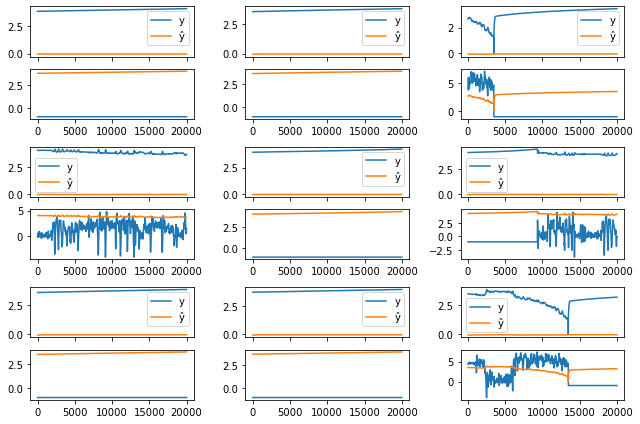

In [ ]:
lrn.show_results()

## Dual CRNN

In [ ]:
#export
class DualCRNN(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,main_input_size,co_input_size,output_size,init_sz=100,tcn_hidden_size=100,tcn_layer=8,rnn_hidden_size=100,
                 rnn_layer=1,linear_layer = 1,main_init_est = True,main_init_prop = True,**kwargs):
        super().__init__()
        store_attr('main_input_size,co_input_size,main_init_est,main_init_prop,init_sz')
        
        rnn_kwargs = dict(hidden_size=rnn_hidden_size,num_layers=rnn_layer,stateful=True,ret_full_hidden=True)
        rnn_kwargs = dict(rnn_kwargs, **kwargs)
        
        self.co_tcn = TCN(co_input_size,rnn_hidden_size,tcn_layer,tcn_hidden_size,stateful=True) 
        self.main_tcn = TCN(main_input_size,rnn_hidden_size,tcn_layer,tcn_hidden_size,stateful=True)
        
        self.co_rnn = RNN(rnn_hidden_size,**rnn_kwargs) 
        self.main_rnn = RNN(rnn_hidden_size,**rnn_kwargs) 

#         self.co_estimator = SeqLinear(rnn_hidden_size,output_size,hidden_layer=linear_layer)
        self.main_estimator = SeqLinear(rnn_hidden_size,output_size,hidden_layer=linear_layer)

    def forward(self, x,init_state = None):
        bs = x.shape[0]
        if init_state is None:
            init_state = self.main_rnn._get_hidden(bs) if self.main_init_prop else self.co_rnn._get_hidden(bs)
        
        
        x_co = x[...,:self.co_input_size]
        x_main = x[...,:self.main_input_size]
        
        #TCN Layer
        x_co = self.co_tcn(x_co)
        x_main = self.main_tcn(x_main)
        
            
        #RNN Layer 
        if init_state is None:
#             import pdb; pdb.set_trace()
            if self.main_init_est:
                out_init,h_init = self.main_rnn(x_main[:,:self.init_sz])
                out_main,_ = self.main_rnn(x_main[:,self.init_sz:],h_init)
                out_co,_ = self.co_rnn(x_co[:,self.init_sz:],h_init)  
                out_main=torch.cat([out_init,out_main],2) 
                out_co=torch.cat([out_init,out_co],2) 
            else:
                out_init,h_init = self.co_rnn(x_co[:,:self.init_sz])
                out_co,_ = self.co_rnn(x_co[:,self.init_sz:],h_init)
                out_main,_ = self.main_rnn(x_main[:,self.init_sz:],h_init)  
                out_main=torch.cat([out_init,out_main],2) 
                out_co=torch.cat([out_init,out_co],2) 
        else:  
            out_co,_ = self.co_rnn(x_co,init_state)         
            out_main,_ = self.main_rnn(x_main,init_state)
            
            
#         import pdb; pdb.set_trace()
            
        #Shared Linear Layer
        est_co = self.main_estimator(out_co[-1])
        est_main = self.main_estimator(out_main[-1])

#         import pdb; pdb.set_trace()   
        return est_main,est_co, out_co,out_main

    def get_main_crnn(self):
        crnn_model = CRNN(1,1)
        crnn_model.cnn = self.main_tcn
        
        simple_rnn_model = SimpleRNN(1,1)
        simple_rnn_model.rnn = self.main_rnn
        simple_rnn_model.final = self.main_estimator
        crnn_model.rnn = simple_rnn_model
        return crnn_model
    
    
    def get_co_crnn(self):
        crnn_model = CRNN(1,1)
        crnn_model.cnn = self.co_tcn
        
        simple_rnn_model = SimpleRNN(1,1)
        simple_rnn_model.rnn = self.co_rnn
        simple_rnn_model.final = self.main_estimator
        crnn_model.rnn = simple_rnn_model
        return crnn_model

In [ ]:
model = DualCRNN(1,2,1,init_sz=500,main_init_est=False,main_init_prop=False)
lrn = Learner(db,model,loss_func=nn.MSELoss(),cbs=ProDiagTrainer(),opt_func=ranger)
lrn.add_cb(TbpttResetCB())

In [ ]:
model.get_main_crnn()

CRNN(
  (cnn): TCN(
    (conv_layers): Sequential(
      (0): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(1, 100, kernel_size=(2,), stride=(1,))
          (1): Mish()
        )
        (residual): Conv1d(1, 100, kernel_size=(1,), stride=(1,))
      )
      (1): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(100, 100, kernel_size=(2,), stride=(1,), dilation=(2,))
          (1): Mish()
        )
      )
      (2): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(100, 100, kernel_size=(2,), stride=(1,), dilation=(4,))
          (1): Mish()
        )
      )
      (3): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(100, 100, kernel_size=(2,), stride=(1,), dilation=(8,))
          (1): Mish()
        )
      )
      (4): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(100, 100, kernel_size=(2,), stride=(1,), dilation=(16,))
          (1): Mish()
        )
      )
      (5): TCN_Bloc

In [ ]:
# btch = 6
# plt.figure()
# plt.plot(lrn.y.cpu()[btch,:,0])
# plt.plot(lrn.pred.cpu()[btch,:,0])
# plt.figure()
# plt.plot(lrn.y.cpu()[btch,:,0])
# plt.plot(lrn.pred.cpu()[btch,:,1])

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_models.ipynb.
Converted 01a_IndRNN.ipynb.
Converted 02_learner.ipynb.
Converted 03_dataloaders.ipynb.
Converted 11_dualrnn.ipynb.
Converted 12_TensorQuaternions.ipynb.
Converted 13_HPOpt.ipynb.
Converted index.ipynb.
